In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import DihedralAdherence
from lib import PDBMineQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import gaussian_kde
from pathlib import Path
from tqdm import tqdm
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'tests'

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FuncFormatter

In [138]:
class ProteinDataset(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.X, self.y, self.xres, self.af = torch.load(self.path / f'{id}.pt')
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i], self.xres[i], self.af[i], self.y[i]

In [139]:
lengths = [4096, 512, 256, 256]
path = Path('ml_samples/'+'-'.join([str(l) for l in lengths]))
samples = [f.stem for f in path.iterdir()]

from lib.retrieve_data import retrieve_target_list
ids = ['T1024', 'T1096', 'T1027', 'T1082', 'T1091', 'T1058', 'T1049', 'T1030', 'T1056', 'T1038', 'T1025', 'T1028']
targetlist = retrieve_target_list()
skip = [targetlist.loc[id, 'pdb_code'].upper() for id in ids]
samples = sorted(list(set(samples) - set(skip)))

train, test = train_test_split(samples, test_size=0.35, random_state=42)
torch.save((train, test), 'ml_data/split.pt')
# train, test = to ch.load('ml_data/split.pt')
train_dataset = ConcatDataset([ProteinDataset(s, path) for s in train])
test_dataset = ConcatDataset([ProteinDataset(s, path) for s in test])
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
len(train_dataset), len(test_dataset), len(train_dataset) + len(test_dataset)

(47572, 25179, 72751)

# Brute Force Search

In [6]:
X,xres,af,y = train_dataset[2]

h = 0.5
kdews = [1,1,1,1]
weights = torch.tensor(np.concatenate([np.array([w]*l) for w,l in zip(kdews, lengths)]))
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

[-1.81818182  1.81818182] 9.193181265651215e-05


In [ ]:
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
h = 0.5
results = []
for i in range(0,10,2):
    wi = np.power(2,i)
    for j in range(0,10,2):
        wj = np.power(2,j)
        for k in range(0,10,2):
            wk = np.power(2,k)
            for l in tqdm(range(0,10,2)):
                wl = np.power(2,l)
                ws = [wi,wj,wk,wl]
                weights = np.concatenate([np.array([w]*l) for w,l in zip(ws, lengths)])
                for i in np.random.choice(len(train_dataset), 16):
                # for i,(x, xres, af, y) in enumerate(train_dataset):
                    print(i)
                    x, xres, af, y = train_dataset[i]
                    x = x.numpy()
                    y = y.numpy()
                    kde = gaussian_kde(x, weights=weights, bw_method=h)
                    probs = kde(grid).reshape(phi_grid.shape)
                    kdepeak = grid[:,probs.argmax()]
                    dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
                    results.append([wi,wj,wk,wl,dist])
                    # if i == 15:
                        # break
                    with open ('results_.csv', 'a') as f:
                        f.write(f'{wi},{wj},{wk},{wl},{dist}\n')
df = pd.DataFrame(results, columns=['w4', 'w5', 'w6', 'w7', 'da'])
df.to_csv('results.csv', index=False)

In [82]:
df = pd.read_csv('results.csv')
df['id'] = df.apply(lambda x: '-'.join([str(int(w)) for w in x[['w4', 'w5', 'w6', 'w7']]]), axis=1)

In [129]:
grouped = df.groupby(['w4', 'w5', 'w6', 'w7']).agg(n=('da', 'size'), da=('da', 'mean'), std=('da', 'std'), id=('id', lambda x: x.iloc[0])).reset_index()

In [141]:
grouped[grouped.id.isin(chosen_ids)]

,w4,w5,w6,w7,n,da,std,id
88,1,64,16,64,16,55.497319,52.311558,1-64-16-64
177,4,16,1,16,16,60.636091,71.179443,4-16-1-16
291,16,4,64,4,16,61.851658,75.841171,16-4-64-4
337,16,64,16,16,16,62.103944,55.639732,16-64-16-16
360,16,256,16,1,16,57.602896,54.944407,16-256-16-1
501,256,1,1,4,16,50.555986,42.725184,256-1-1-4
608,256,256,4,64,16,62.775770,56.630056,256-256-4-64


In [119]:
chosen_ids = grouped[grouped.da < grouped.da.quantile(0.01)].id.values
chosen_df = df[df.id.isin(chosen_ids)]

<Axes: ylabel='da'>

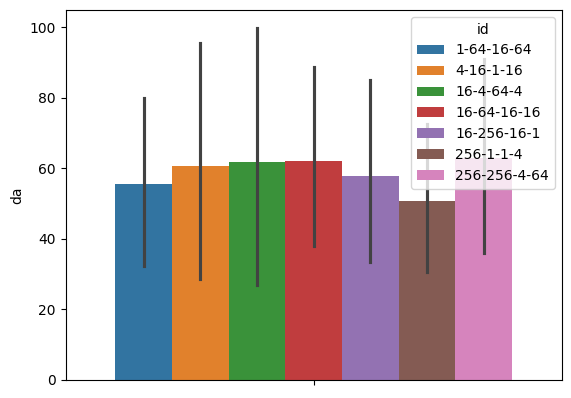

In [139]:
sns.barplot(data=chosen_df, y='da', hue='id')

<Axes: xlabel='da', ylabel='Count'>

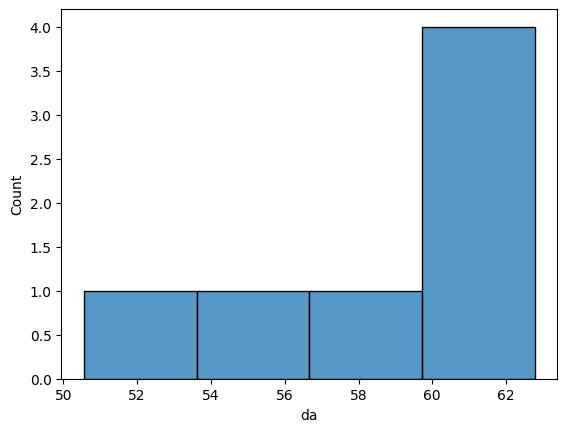

In [135]:
sns.histplot(grouped[grouped.da < grouped.da.quantile(0.01)], x='da')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     da   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.471
Method:                 Least Squares   F-statistic:                              2223.
Date:                Mon, 01 Jul 2024   Prob (F-statistic):                        0.00
Time:                        12:34:17   Log-Likelihood:                         -58806.
No. Observations:               10000   AIC:                                  1.176e+05
Df Residuals:                    9996   BIC:                                  1.176e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
w4             0.2617      0.008     31.951      0.000       0.246       0.278
w5             0.2389      0.008     29.173      0.000       0.223       0.255
w6             0.2432      0.008     29.697      0.000       0.227       0.259
w7             0.2337      0.008     28.532      0.000       0.218       0.250
==============================================================================
Omnibus:                      158.449   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.273
Skew:                          -0.068   Prob(JB):                     2.05e-21
Kurtosis:                       2.542   Cond. No.                         1.73
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

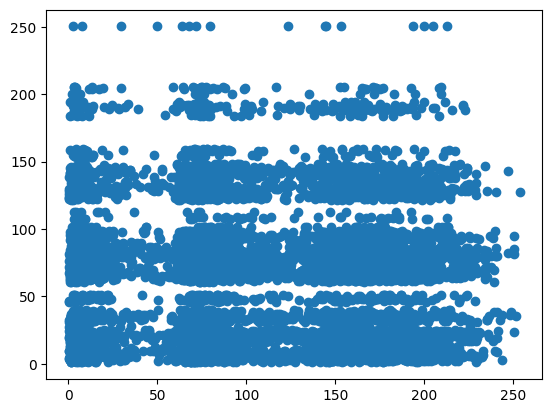

In [128]:
import statsmodels.api as sm

X = df[['w4', 'w5', 'w6', 'w7']]
# X = sm.add_constant(X)
y = df['da']
model = sm.OLS(y, X).fit()

yhat = model.predict(X)
plt.plot(df['da'], yhat, 'o')
model.summary()

# KDE from scratch - backprop

In [82]:
h = 2
h_mat = torch.eye(2) * h
print(h_mat)
h_mat = torch.inverse(h_mat) # 2x2 matrix
print(h_mat)
x = torch.tensor([1.,.23]) # 2x1 "column vector"
print(x)
this = x @ h_mat # x.T @ h_mat: 1x2 @ 2x2 = 1x2 "row vector"
print('this',this)
print('x=',this @ x) # 1x2 @ 2x1 = 1x1 "scalar"

# shortcut
print('x=',x.pow(2).sum() / h)

tensor([[2., 0.],
        [0., 2.]])
tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]])
tensor([1.0000, 0.2300])
this tensor([0.5000, 0.1150])
x= tensor(0.5264)
x= tensor(0.5264)


In [153]:
X.T

tensor([[-119.2000,  113.6000],
        [-115.3000,  112.6000],
        [-117.4000,  132.1000],
        ...,
        [ -51.7000,  130.8000],
        [ -34.8000,  114.3000],
        [ -74.5000,  131.0000]])

In [162]:
from scipy.linalg import solve_triangular
print(X.shape)
solve_triangular(cho_cov, X, lower=True).shape

torch.Size([2, 5120])


(2, 5120)

In [183]:
kdews.grad

tensor([5120., 5120., 5120., 5120.])

In [180]:
kdews = torch.tensor([1.,1.,1.,1.], requires_grad=True)
weights = torch.cat([kdews.repeat(l) for l in lengths])
weights.sum().backward()

In [185]:
diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
torch.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)

tensor(144.0303)

In [186]:
y

tensor([-81.9605, 121.4925])

tensor([ 0.9839, -0.2462, -0.3725, -0.3651])
tensor([-1.8182,  1.8182], dtype=torch.float64) tensor(9.1932e-05, dtype=torch.float64)


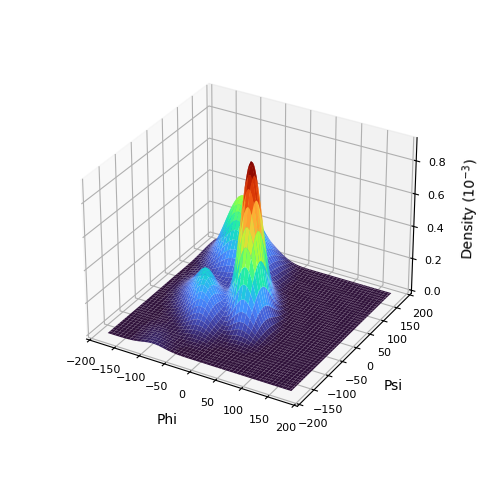

In [214]:
X,xres,af,y = train_dataset[2]

from scipy.stats import gaussian_kde
from scipy.linalg import cholesky
from tqdm import tqdm
kdews = torch.tensor([0.25, 0.25, 0.25, 0.25], requires_grad=True)
weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
# weights = weights / weights.sum()
# X = X.numpy()
# X
# plt.plot(weights)

# Kernel Density Estimation
h = 0.5
cov = np.cov(X, rowvar=True, aweights=weights.detach())
cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal
def K(x):
    # 2 dimensional standard normal distribution
    # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
    return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
def kde(xi):
    xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
    if xi.ndim == 1:
        xi = xi.unsqueeze(1)
    points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
    xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
    xi = xi.T.unsqueeze(-1)
    likelihood = K(points.unsqueeze(0) - xi) * weights
    likelihood = likelihood.sum(dim=1) / weights.sum()
    return likelihood

# Find most likely dihedral angles
xray_likelihood = kde(y)
nll = -torch.log(xray_likelihood)
nll.backward()
print(kdews.grad)

phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = torch.tensor(np.vstack([phi_grid.ravel(), psi_grid.ravel()]))
probs = kde(grid).reshape(phi_grid.shape).detach()
kdepeak = grid[:,probs.argmax()]
print(kdepeak, probs.max())

# diff = lambda x1, x2: torch.min(torch.abs(x1 - x2), 360 - torch.abs(x1 - x2))
# dist_to_xray = torch.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
# print(dist_to_xray.backward())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
ax.dist = 5
plt.tight_layout()

In [ ]:
kde = gaussian_kde(X, weights=weights, bw_method=h)
kde([0,0])
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()

In [66]:
torch.log(torch.tensor(1.))

tensor(0.)

In [98]:
len(trainloader)

93

In [99]:
next(iter(trainloader))[3].shape

torch.Size([512, 2])

In [145]:
torch.pow(2, torch.tensor([0.,5.,6.,7.]))

tensor([  1.,  32.,  64., 128.])

In [151]:
kdewlogs

tensor([1.0000, 5.0000, 6.0000, 7.0000], requires_grad=True)

In [ ]:
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular

kdewlogs = torch.tensor([1.,5.,6.,7.], requires_grad=True)
kdews = torch.pow(2, kdewlogs)
weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
optimizer = torch.optim.SGD([kdewlogs], lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam([kdewlogs], lr=3e-4)

h = 0.5

nlls = []
best_weights = kdews
best_lost = 1e9
for Xbatch,xres,af,ybatch in trainloader:
    nll = 0
    kdews = torch.pow(2, kdewlogs)
    weights = torch.cat([kdews[i].repeat(l) for i,l in enumerate(lengths)])
    for X,y in tqdm(zip(Xbatch, ybatch)):
        # Kernel Density Estimation
        cov = np.cov(X, rowvar=True, aweights=weights.detach())
        cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
        h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal
        def K(x):
            # 2 dimensional standard normal distribution
            # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
            return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
        def kde(xi):
            xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
            if xi.ndim == 1:
                xi = xi.unsqueeze(1)
            points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
            xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
            xi = xi.T.unsqueeze(-1)
            likelihood = K(points.unsqueeze(0) - xi) * weights
            likelihood = likelihood.sum(dim=1) / weights.sum()
            return likelihood
        
        # Optimize xray prob
        xray_likelihood = kde(y)
        if xray_likelihood == 0:
            continue
        nlli = -torch.log(xray_likelihood)
        nll += nlli
    if nll < best_lost:
        best_lost = nll
        best_weights = kdews
    optimizer.zero_grad()
    nll.backward()
    optimizer.step()
    print(nll, kdewlogs.grad, kdewlogs, torch.pow(2, kdewlogs))
    nlls.append(nll)
nlls = torch.tensor(nlls)

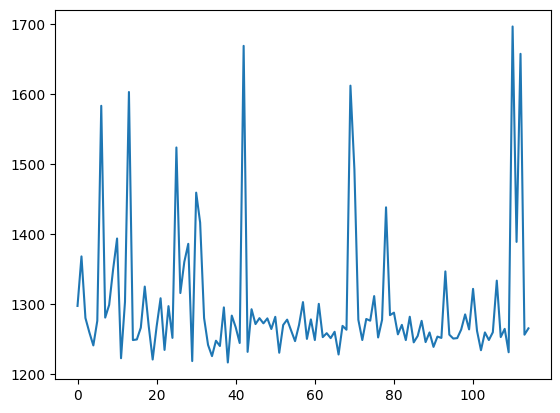

In [158]:
plt.plot(nlls.detach())

[-118.18181818  125.45454545] 4.965032505833786e-05
tensor([-66.2305, -35.4409]) [2.57286341e-05]


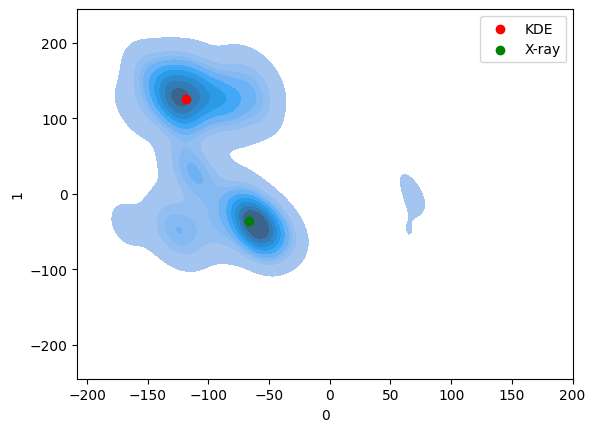

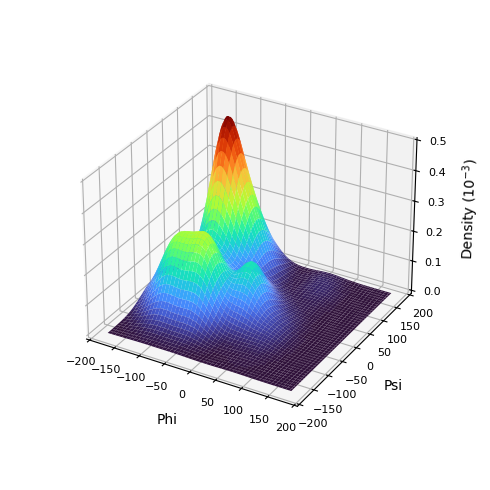

In [135]:
optim_kdews = torch.tensor([0.2458, 0.6339, 5.8508, 0.6577])
# optim_kdews = torch.tensor([1.,32.,64.,128.])
# optim_kdews = torch.tensor([1.,1.,1.,1.])
weights = torch.cat([optim_kdews[i].repeat(l) for i,l in enumerate(lengths)])

X,xres,af,y = test_dataset[2]

# Kernel Density Estimation
kde = gaussian_kde(X, weights=weights, bw_method=h)
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
probs = kde(grid).reshape(phi_grid.shape)
kdepeak = grid[:,probs.argmax()]
kdepeak, probs.max()
print(kdepeak, probs.max())
print(y, kde(y))


X = X.clone()
X[X==0] = np.nan
sns.kdeplot(pd.DataFrame(X.numpy().T), x=0, y=1, fill=True)
# plt.scatter(X[0], X[1])
plt.scatter(kdepeak[0], kdepeak[1], c='r', label='KDE')
plt.scatter(y[0], y[1], c='g', label='X-ray')
plt.legend()

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))

ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.tight_layout()

# Optimize weights for peaks

In [21]:
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]
print(X[:,s[0]:s[1]].shape)
print(X[:,s[1]:s[2]].shape)
print(X[:,s[2]:s[3]].shape)
print(X[:,s[3]:    ].shape)

torch.Size([2, 4096])
torch.Size([2, 512])
torch.Size([2, 256])
torch.Size([2, 256])


In [127]:
~torch.isnan(X)

TypeError: isnan() got an unexpected keyword argument 'dim'

torch.Size([2, 5120])
tensor(1546)
torch.Size([2, 3574])


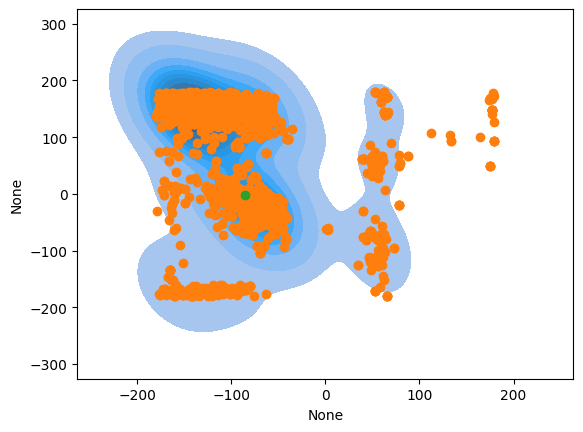

In [152]:
X,xres,af,y = test_dataset[4]
mask = (X[0] == 0) & (X[1] == 0)
print(X.shape)
print(mask.sum())
X = X[:,~mask]
print(X.shape)
sns.kdeplot(x=X[0], y=X[1], fill=True, bw_method=0.5)
plt.scatter(X[0],X[1])
plt.scatter(y[0],y[1])

In [ ]:
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular

X,xres,af,y = test_dataset[4]
print(X.shape)
def get_preweights(X):
    mask = (X[0] == 0) & (X[1] == 0)
    X = X[:,~mask]
    n_eff = X.shape[1]
    h=0.5
    cov = np.cov(X, rowvar=True)
    cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
    h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal

    def K(x):
        # 2 dimensional standard normal distribution
        # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
        return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
    def kde_pre_weights(xi):
        xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
        if xi.ndim == 1:
            xi = xi.unsqueeze(1)
        points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
        xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
        xi = xi.T.unsqueeze(-1)
        likelihood = K(points.unsqueeze(0) - xi)# * weights
        # likelihood = likelihood.sum(dim=1) / weights.sum()
        return likelihood

    phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
    grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
    preweights = kde_pre_weights(grid).reshape(*phi_grid.shape,-1)
    return preweights, n_eff

diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))

preweights = []
n_effs = []
for i in range(3):
    preweight, n_eff = get_preweights(X[:,s[i]:s[i+1]])
    preweights.append(preweight)
    n_effs.append(n_eff)
preweight, n_eff = get_preweights(X[:,s[3]:])
preweights.append(preweight)
n_effs.append(n_eff)

# Peak with no weights
probs = torch.stack([p.sum(dim=-1) for p in preweights]).sum(dim=0) / sum(n_effs)
phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
kdepeak = grid[:,probs.argmax()]
dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
print(y, kdepeak, probs.max(), dist)

cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
ax.plot(kdepeak[0],kdepeak[1],(probs.min(), probs.max()*1.2), linewidth=2, label='kdepeak')
ax.plot(y[0],y[1],(probs.min(), probs.max()*1.2), linewidth=2, label='xray')
ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))
ax.set_xlabel('Phi', fontsize=10, labelpad=10)
ax.set_ylabel('Psi', fontsize=10, labelpad=10)
ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.zaxis.set_tick_params(labelsize=8)
ax.set_box_aspect(aspect=None, zoom=0.8)
# ax.dist = 5
plt.legend()
plt.tight_layout()

# try different weights:
dists = []
for w1 in [0.,0.25,0.5,0.75,1.]:
    kdews = torch.ones(4) / 4
    kdews[0] = w1
    kdews[1] = 1 - w1
    # n = torch.cat([kdews[i].repeat(n) for i,n in enumerate(n_effs)])
    n = [w*n for w,n in zip(kdews, n_effs)]
    probs = torch.stack([(p * kdews[i]).sum(dim=-1) for i,p in enumerate(preweights)]).sum(dim=0) / sum(n)
    kdepeak = grid[:,probs.argmax()]
    dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
    dists.append(dist)
    print(y, kdepeak, probs.max(), dist)

    cm = plt.get_cmap('turbo')
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(phi_grid, psi_grid, probs, cmap=cm)
    ax.plot(kdepeak[0],kdepeak[1],(probs.min(), probs.max()*1.2), linewidth=2, label='kdepeak')
    ax.plot(y[0],y[1],(probs.min(), probs.max()*1.2), linewidth=2, label='xray')
    ax.zaxis.set_major_formatter(FuncFormatter(lambda x,pos:f'{x * 10e3:.1f}'))
    ax.set_xlabel('Phi', fontsize=10, labelpad=10)
    ax.set_ylabel('Psi', fontsize=10, labelpad=10)
    ax.set_zlabel(r'Density $(10^{-3})$', fontsize=10, labelpad=10)
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    ax.zaxis.set_tick_params(labelsize=8)
    ax.set_box_aspect(aspect=None, zoom=0.8)
    plt.legend()
    # ax.dist = 5
    ax.set_title(f'w1={w1}')
    plt.tight_layout()
plt.close()
# plt.plot(dists)

In [183]:
len(train_dataset)

47572

In [208]:
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular

def get_preweights(X):
    mask = (X[0] == 0) & (X[1] == 0)
    X = X[:,~mask]
    n_eff = X.shape[1]
    h=0.5
    cov = np.cov(X, rowvar=True)
    cho_cov = torch.tensor(cholesky(cov, lower=True)) * h # lower triangular
    h_det = cho_cov.diag().prod() # torch.det(cho_cov) # product of diagonal

    def K(x):
        # 2 dimensional standard normal distribution
        # return torch.exp(-0.5 * x.pow(2).sum(dim=1) / h) / (2 * np.pi * torch.sqrt(h_det))
        return torch.exp(-0.5 * x.pow(2).sum(dim=1)) / (2 * np.pi * h_det)
    def kde_pre_weights(xi):
        xi = torch.tensor(xi) if not isinstance(xi, torch.Tensor) else xi
        if xi.ndim == 1:
            xi = xi.unsqueeze(1)
        points = torch.tensor(solve_triangular(cho_cov, X, lower=True))
        xi = torch.tensor(solve_triangular(cho_cov, xi, lower=True))
        xi = xi.T.unsqueeze(-1)
        likelihood = K(points.unsqueeze(0) - xi)# * weights
        # likelihood = likelihood.sum(dim=1) / weights.sum()
        return likelihood

    phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(-180, 180, 100))
    grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
    preweights = kde_pre_weights(grid).reshape(*phi_grid.shape,-1)
    return preweights, n_eff

diff = lambda x1, x2: min(abs(x1 - x2), 360 - abs(x1 - x2))
s = [sum(lengths[:i]) for i,l in enumerate(lengths)]

import itertools
grid_size = 5
values = np.linspace(0, 1, grid_size)
combinations = [comb for comb in itertools.product(values, repeat=4) if sum(comb) == 1]

results = []
for i,(X,xres,af,y) in tqdm(enumerate(train_dataset)):
    if i == 2:
        break
    
    try:
        preweights = []
        n_effs = []
        for i in range(3):
            preweight, n_eff = get_preweights(X[:,s[i]:s[i+1]])
            preweights.append(preweight)
            n_effs.append(n_eff)
        preweight, n_eff = get_preweights(X[:,s[3]:])
        preweights.append(preweight)
        n_effs.append(n_eff)

        phi_grid, psi_grid = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(-180, 180, 360))
        grid = np.vstack([phi_grid.ravel(), psi_grid.ravel()])
    except Exception as e:
        print(e)
        continue
    
    for w1,w2,w3,w4 in combinations:
        kdews = torch.tensor([w1,w2,w3,w4])
        n = [w*n for w,n in zip(kdews, n_effs)]
        probs = torch.stack([(p * kdews[i]).sum(dim=-1) for i,p in enumerate(preweights)]).sum(dim=0) / sum(n)
        kdepeak = grid[:,probs.argmax()]
        dist = np.sqrt(diff(y[0], kdepeak[0])**2 + diff(y[1], kdepeak[1])**2)
        # print(y, kdepeak, probs.max(), dist)
        results.append([w1,w2,w3,w4,dist.item()])
results = pd.DataFrame(results, columns=['w1', 'w2', 'w3', 'w4', 'da'])
results.to_csv('results.csv', index=False)

0it [00:00, ?it/s]

2it [00:04,  2.14s/it]
